# 제조 공정 예측 유지 보수하기

## 01. 데이터 소개 및 분석 프로세스 수립

### 데이터 수집  
데이터 소스: https://www.kaggle.com/datasets/yuansaijie0604/xinjiang-pm?resource=download  

사용되는 데이터 파일 목록
- PdM error
- PdM failure
- PdM machines
- PdM components
- PdM telemetry.

### 데이터 전처리  
각 데이터별 전처리 진행  

Feature 종류
- 일정 시간 통계량 Feature
- 범주형 Feature
- Target Feature

### 모델 생성  
- XGBoost Model 생성
- 모델 평가

### 모델 평가 및 의사결정
- Feature Importance

matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


## 02. 데이터 준비를 위한 EDA 및 전처리

### 0. 데이터 불러오기

In [2]:
! pip install scikit-learn
! pip install scikit-plot

In [3]:
# 필요한 파이썬 라이브러리 불러오기

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

import scikitplot as skplt

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [5]:
telemetry = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_telemetry.csv", error_bad_lines=False)
errors = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_errors.csv", error_bad_lines=False)
maint = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_maint.csv", error_bad_lines=False)
failures = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_failures.csv", error_bad_lines=False)
machines = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/09_predictive_maintenance/PdM_machines.csv", error_bad_lines=False)

Skipping line 92490: expected 6 fields, saw 9



In [6]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


### 1. 각 데이터별 전처리

#### telemetry

In [7]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [8]:
telemetry["machineID"].nunique()

100

> 데이터 타입

In [9]:
telemetry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968588 entries, 0 to 968587
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   968588 non-null  object 
 1   machineID  968588 non-null  int64  
 2   volt       968588 non-null  float64
 3   rotate     968588 non-null  float64
 4   pressure   968588 non-null  float64
 5   vibration  968588 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 44.3+ MB


In [10]:
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [11]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

> 변수별 분포

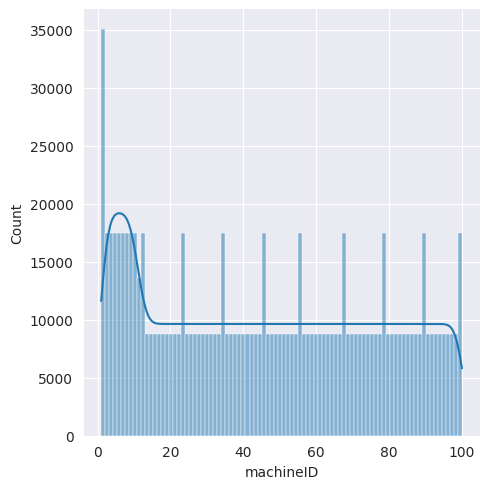

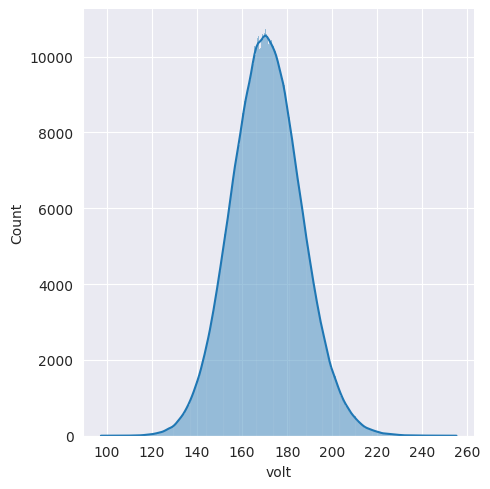

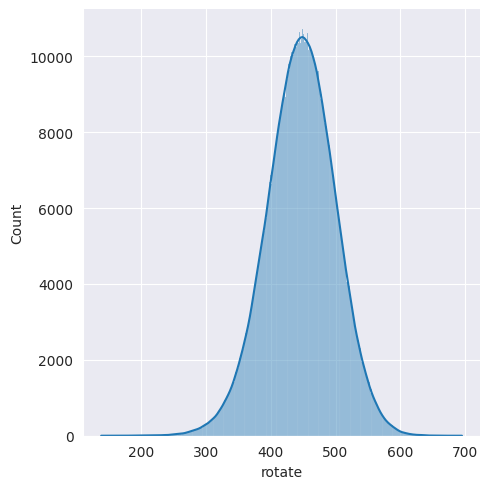

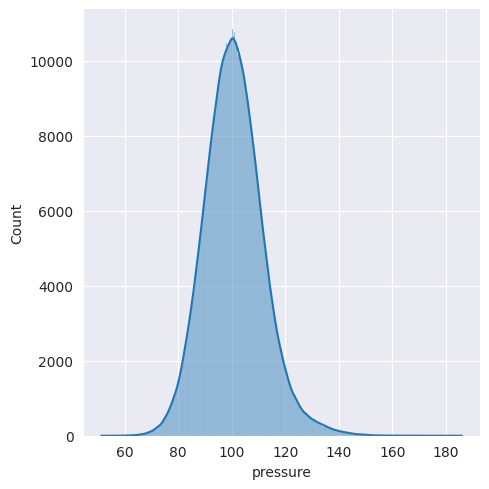

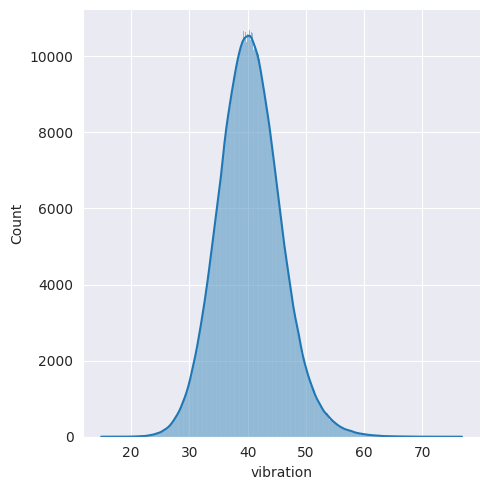

In [12]:
# 데이터 컬럼 타입이 np.number인 것만 가져오기
numeric_data = telemetry.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 np.number인 컬럼 이름들 가져오기
l = numeric_data.columns.values
number_of_columns = 4
number_of_rows = len(l) - 1 / number_of_columns

# 컬럼별 히스토그램 그리기
for i in range(0, len(l)):
  target_data = numeric_data[l[i]]

  target_data_wo_zero = target_data[target_data>0]
  sns.displot(target_data_wo_zero, kde=True)

> 시계열 그래프 그려보기

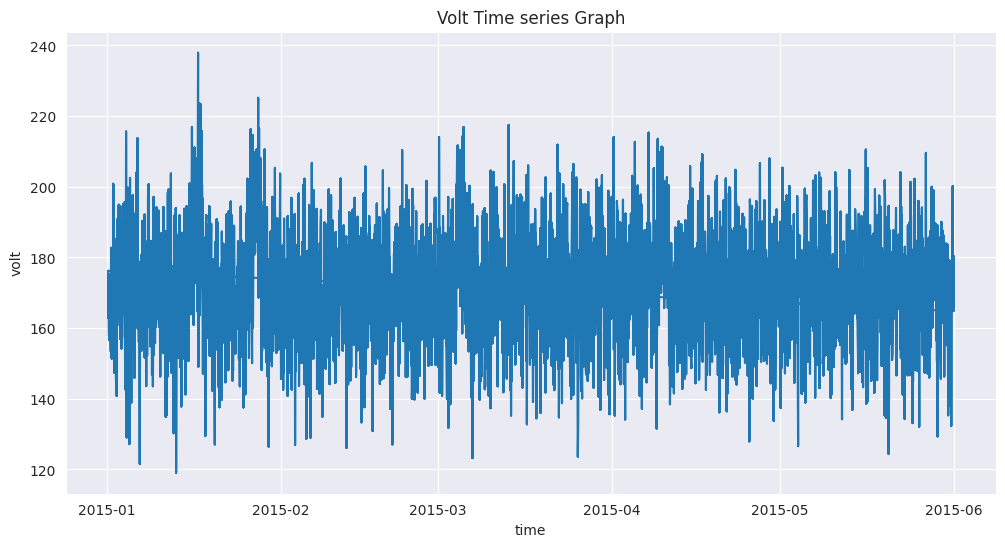

In [13]:
plot_df = telemetry.loc[
    (telemetry["machineID"] == 1)
    & (telemetry["datetime"] > pd.to_datetime("2015-01-01"))
    & (telemetry["datetime"] < pd.to_datetime("2015-06-01")), ["datetime", "volt"]
]

plt.figure(figsize=(12, 6))
plt.plot(plot_df["datetime"], plot_df["volt"])
plt.title("Volt Time series Graph")
plt.ylabel("volt")

adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = "%m=%d"
plt.xlabel("time")
plt.show()

#### errors

In [14]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [15]:
errors.tail()

,datetime,machineID,errorID
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


In [16]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3919 non-null   object
 1   machineID  3919 non-null   int64 
 2   errorID    3919 non-null   object
dtypes: int64(1), object(2)
memory usage: 92.0+ KB


> 데이터 타입

In [17]:
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")
errors["errorID"] = errors["errorID"].astype("category")
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


> 컬럼별 개수

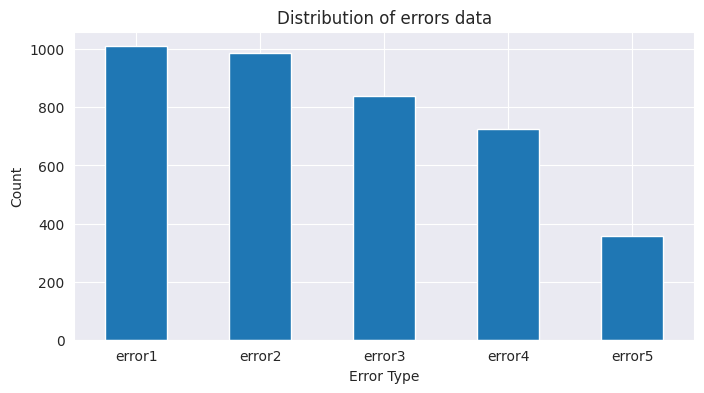

In [18]:
plt.figure(figsize=(8, 4))
errors["errorID"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of errors data")
plt.ylabel("Count")
plt.xlabel("Error Type")
plt.show()

#### maint

In [19]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [20]:
maint.tail()

,datetime,machineID,comp
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


In [21]:
maint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   3286 non-null   object
 1   machineID  3286 non-null   int64 
 2   comp       3286 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.1+ KB


> 데이터 타입

In [22]:
maint["datetime"] = pd.to_datetime(maint["datetime"], format="%Y-%m-%d %H:%M:%S")
maint["comp"] = maint["comp"].astype("category")
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

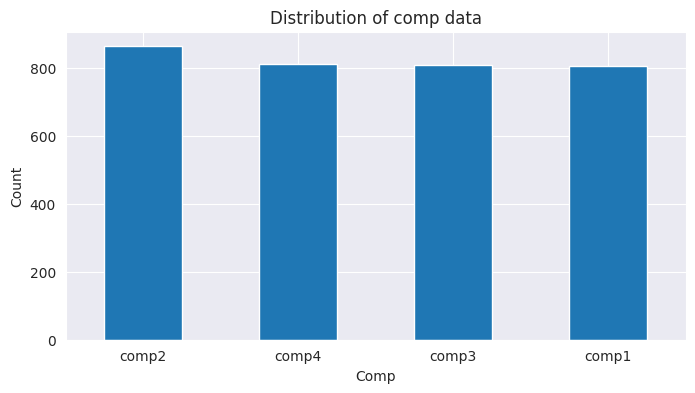

In [23]:
plt.figure(figsize=(8, 4))
maint["comp"].value_counts().plot(kind="bar", rot=0)
plt.title("Distribution of comp data")
plt.ylabel("Count")
plt.xlabel("Comp")
plt.show()

#### machines

In [24]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [25]:
machines.tail()

,machineID,model,age
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14
99,100,model4,5


In [26]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


> 데이터 타입

In [27]:
machines['model'] = machines["model"].astype("category")
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

> 모델 번호별 age 분포

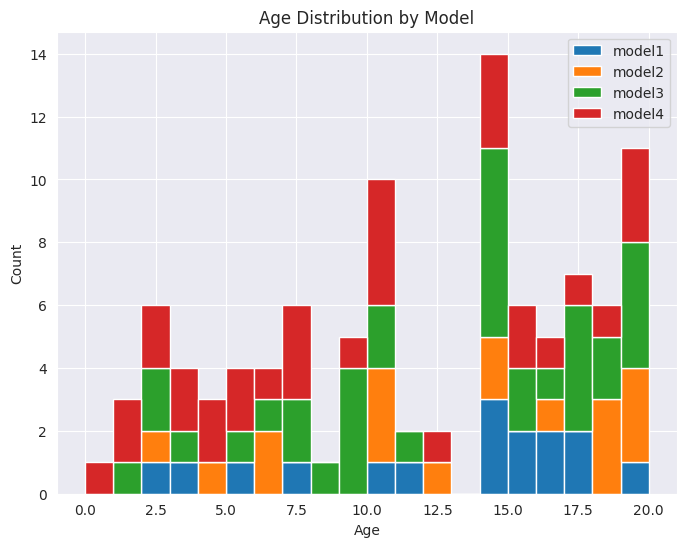

In [28]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    machines.loc[machines["model"] == "model1", "age"],
    machines.loc[machines["model"] == "model2", "age"],
    machines.loc[machines["model"] == "model3", "age"],
    machines.loc[machines["model"] == "model4", "age"]],
                      20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Age Distribution by Model")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

#### failures

In [29]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [30]:
failures.tail()

,datetime,machineID,failure
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


In [31]:
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   datetime   761 non-null    object
 1   machineID  761 non-null    int64 
 2   failure    761 non-null    object
dtypes: int64(1), object(2)
memory usage: 18.0+ KB


> 데이터 타입

In [32]:
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")
failures["failure"] = failures["failure"].astype("category")
failures.dtypes

datetime     datetime64[ns]
machineID             int64
failure            category
dtype: object

In [33]:
failures.describe(include="all")

,datetime,machineID,failure
count,761,761.000000,761
unique,302,NaN,4
top,2015-01-02 03:00:00,NaN,comp2
freq,18,NaN,259
first,2015-01-02 03:00:00,NaN,NaN
last,2015-12-31 06:00:00,NaN,NaN
mean,NaN,51.911958,NaN
std,NaN,29.515542,NaN
min,NaN,1.000000,NaN
25%,NaN,24.000000,NaN


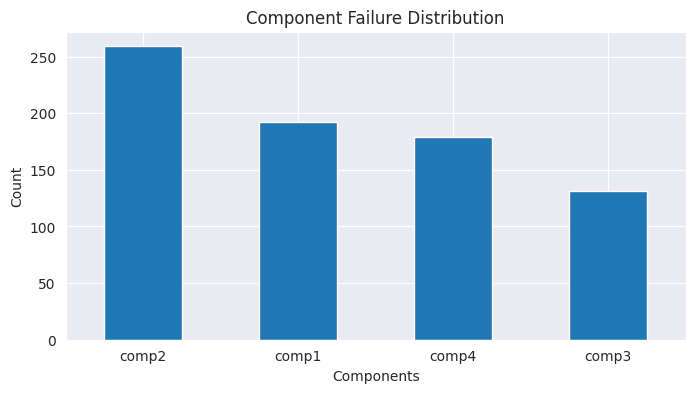

In [34]:
plt.figure(figsize=(8, 4))
failures["failure"].value_counts().plot(kind="bar", rot=0)
plt.title("Component Failure Distribution")
plt.ylabel("Count")
plt.xlabel("Components")
plt.show()

### 2. Feature 정제

#### 일정 시간 통계량 Feature 생성

In [35]:
temp = []
fields = ["volt", "rotate", "pressure", "vibration"]

> 참고

In [36]:
index = pd.date_range("1/1/2000", periods=9, freq='T')
series = pd.Series(range(9), index=index)
series

2000-01-01 00:00:00    0
2000-01-01 00:01:00    1
2000-01-01 00:02:00    2
2000-01-01 00:03:00    3
2000-01-01 00:04:00    4
2000-01-01 00:05:00    5
2000-01-01 00:06:00    6
2000-01-01 00:07:00    7
2000-01-01 00:08:00    8
Freq: T, dtype: int64

In [37]:
series.resample('3T', label='right', closed='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:03:00     6
2000-01-01 00:06:00    15
2000-01-01 00:09:00    15
Freq: 3T, dtype: int64

In [38]:
# 머신별로 각 시간 범위마다의 평균 값을 구하기 (temp[0]은 voltage에 대한 값)
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean()
    for col in fields
]
temp[0].head()

machineID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 09:00:00,170.028993,167.694328,176.972454,168.919898,172.522984,147.757049,182.690139,169.493314,195.237026,163.943592,...,169.565805,170.319140,160.050650,169.532985,183.925906,159.717088,158.528658,165.182129,166.861027,159.615566
2015-01-01 12:00:00,164.192565,180.419031,158.335330,170.170964,163.752781,164.163202,165.183285,175.984806,191.419434,168.266274,...,162.233275,182.693906,173.829574,169.941757,162.591156,184.434245,159.695671,166.887794,171.427877,184.748096
2015-01-01 15:00:00,168.134445,178.181316,159.266254,174.794830,183.687350,166.864158,175.786908,160.747287,167.800293,172.399917,...,175.151364,162.058766,170.448346,163.201680,190.438009,162.573535,175.085402,175.263339,160.045777,161.850332
2015-01-01 18:00:00,165.514453,172.819468,175.497495,155.885896,170.044798,168.653821,179.404746,167.720356,181.281871,176.205797,...,180.025605,165.466575,170.555552,155.303655,166.948809,175.967724,175.341739,179.742382,172.525338,179.727290
2015-01-01 21:00:00,168.809347,171.588752,171.272547,174.578644,169.457772,166.999611,171.849368,187.779835,177.233726,175.020379,...,175.999188,172.169763,168.066457,164.007219,181.428114,177.198419,175.009913,169.250730,170.348106,162.109000


In [39]:
# 머신별로 각 시간 범위마다의 평균 값을 구하기 (temp[0]은 voltage에 대한 값) - unstack을 이용해 각 machineID 항목별로 보기 더 용이하도록 작업
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").mean().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00    170.028993
           2015-01-01 12:00:00    164.192565
           2015-01-01 15:00:00    168.134445
           2015-01-01 18:00:00    165.514453
           2015-01-01 21:00:00    168.809347
dtype: float64

In [40]:
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + "_mean_3h" for i in fields]
telemetry_mean_3h.reset_index(inplace=True)
telemetry_mean_3h.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


In [41]:
# 머신별로 각 시간 범위마다의 표준편차 값을 구하기 (temp[0]은 voltage에 대한 값)
temp = [
    pd.pivot_table(
        telemetry,
        index="datetime",
        columns="machineID",
        values=col).resample("3H", closed="left", label="right").std().unstack()
    for col in fields
]
temp[0].head()

machineID  datetime           
1          2015-01-01 09:00:00     6.721032
           2015-01-01 12:00:00     7.596570
           2015-01-01 15:00:00    10.124584
           2015-01-01 18:00:00     4.673269
           2015-01-01 21:00:00    14.752132
dtype: float64

In [42]:
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + "_sd_3h" for i in fields]
telemetry_sd_3h.reset_index(inplace=True)
telemetry_sd_3h.head()

,machineID,datetime,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,14.752132,47.048609,4.244158,2.207884


In [43]:
telemetry_feat = pd.concat([
    telemetry_mean_3h,
    telemetry_sd_3h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884


In [44]:
telemetry_feat.describe()

,machineID,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h
count,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164
std,28.866119,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278
25%,25.750000,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790
50%,50.500000,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955
75%,75.250000,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595


#### 범주형 Feature 생성

> error 데이터

In [45]:
error_count = pd.get_dummies(errors)
error_count.columns = ["datetime", "machineID", "error1", "error2", "error3", "error4", "error5"]
error_count.head(15)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
5,2015-01-25 15:00:00,1,0,0,0,1,0
6,2015-01-27 04:00:00,1,1,0,0,0,0
7,2015-03-03 22:00:00,1,0,1,0,0,0
8,2015-03-05 06:00:00,1,1,0,0,0,0
9,2015-03-20 18:00:00,1,1,0,0,0,0


In [46]:
error_count_grouped = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count_grouped.head(15)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
5,1,2015-01-25 15:00:00,0,0,0,1,0
6,1,2015-01-27 04:00:00,1,0,0,0,0
7,1,2015-03-03 22:00:00,0,1,0,0,0
8,1,2015-03-05 06:00:00,1,0,0,0,0
9,1,2015-03-20 18:00:00,1,0,0,0,0


In [47]:
error_count_filtered = telemetry[["datetime", "machineID"]].merge(
    error_count_grouped,
    on=["machineID", "datetime"],
    how="left"
).fillna(0.0)

error_count_filtered.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0


In [48]:
error_count_filtered.describe()

,machineID,error1,error2,error3,error4,error5
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,0.001147,0.001128,0.000958,0.000813,0.000392
std,30.450409,0.033848,0.033573,0.030938,0.028493,0.019803
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


>maint 데이터

In [49]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [50]:
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]
comp_rep.head(15)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2014-06-01 06:00:00,1,0,1,0,0
1,2014-07-16 06:00:00,1,0,0,0,1
2,2014-07-31 06:00:00,1,0,0,1,0
3,2014-12-13 06:00:00,1,1,0,0,0
4,2015-01-05 06:00:00,1,0,0,0,1
5,2015-01-05 06:00:00,1,1,0,0,0
6,2015-01-20 06:00:00,1,0,0,1,0
7,2015-01-20 06:00:00,1,1,0,0,0
8,2015-02-04 06:00:00,1,0,0,0,1
9,2015-02-04 06:00:00,1,0,0,1,0


In [51]:
comp_rep_grouped = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()
comp_rep_grouped.head(15)

,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1
5,1,2015-01-20 06:00:00,1,0,1,0
6,1,2015-02-04 06:00:00,0,0,1,1
7,1,2015-02-19 06:00:00,0,0,1,0
8,1,2015-03-06 06:00:00,1,0,0,0
9,1,2015-03-21 06:00:00,1,0,0,0


In [52]:
comp_rep = telemetry[["datetime", "machineID"]].merge(
    comp_rep_grouped,
    on=["machineID", "datetime"],
    how="outer"
).fillna(0.0).sort_values(by=["machineID", "datetime"])

comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
968588,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
968589,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
968590,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
968591,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [53]:
components = ["comp1", "comp2", "comp3", "comp4"]

In [54]:
for comp in components:
  print(f"comp: {comp}")
  print(-comp_rep[comp].isnull())

comp: comp1
968588    True
968589    True
968590    True
968591    True
0         True
          ... 
968583    True
968584    True
968585    True
968586    True
968587    True
Name: comp1, Length: 968953, dtype: bool
comp: comp2
968588    True
968589    True
968590    True
968591    True
0         True
          ... 
968583    True
968584    True
968585    True
968586    True
968587    True
Name: comp2, Length: 968953, dtype: bool
comp: comp3
968588    True
968589    True
968590    True
968591    True
0         True
          ... 
968583    True
968584    True
968585    True
968586    True
968587    True
Name: comp3, Length: 968953, dtype: bool
comp: comp4
968588    True
968589    True
968590    True
968591    True
0         True
          ... 
968583    True
968584    True
968585    True
968586    True
968587    True
Name: comp4, Length: 968953, dtype: bool


In [55]:
for comp in components:
  comp_rep.loc[comp_rep[comp] < 1, comp] = None
  comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
  comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))

In [56]:
comp_rep

,datetime,machineID,comp1,comp2,comp3,comp4
968588,2014-06-01 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,NaT
968589,2014-07-16 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,2014-07-16 06:00:00
968590,2014-07-31 06:00:00,1,NaT,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
968591,2014-12-13 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
0,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
...,...,...,...,...,...,...
968583,2016-01-01 02:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
968584,2016-01-01 03:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
968585,2016-01-01 04:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00
968586,2016-01-01 05:00:00,100,2015-10-10 06:00:00,2015-12-24 06:00:00,2015-10-10 06:00:00,2015-11-09 06:00:00


In [57]:
comp_rep = comp_rep.loc[comp_rep["datetime"] > pd.to_datetime("2015-01-01")]
comp_rep.head(50)

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
1,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
2,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
3,2015-01-01 07:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
4,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
5,2015-01-01 08:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
6,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
7,2015-01-01 09:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
8,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
9,2015-01-01 10:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


In [58]:
for comp in components:
  comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
2,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
3,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
4,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333


In [59]:
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,54.634332,51.758970,53.299393,52.278293
std,30.450409,63.826724,60.670415,59.018920,57.948910
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,13.333333,11.875000,13.208333,12.833333
50%,45.000000,33.291667,29.333333,32.625000,31.875000
75%,73.000000,70.125000,66.041667,68.375000,68.375000
max,100.000000,491.958333,348.958333,370.958333,394.958333


#### 최종 Feature 정의

In [60]:
final_feat = telemetry_feat.merge(error_count_filtered, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(comp_rep, on=["datetime", "machineID"], how="left")
final_feat = final_feat.merge(machines, on=["machineID"], how="left")
final_feat.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h,...,error2,error3,error4,error5,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
1,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
2,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
3,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18
4,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,0.0,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18


In [61]:
final_feat.describe()

,machineID,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h,error1,error2,error3,error4,error5,comp1,comp2,comp3,comp4,age
count,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000,384475.000000
mean,39.746212,170.768289,446.571402,100.815265,40.381497,13.305115,44.457822,8.875305,4.441376,0.001558,0.001654,0.001509,0.001004,0.000731,56.257348,52.021340,54.103286,49.852578,11.004955
std,31.626548,9.485108,33.239041,7.351782,3.462509,6.973298,23.217840,4.646867,2.320209,0.039440,0.040638,0.038811,0.031670,0.027025,65.755342,62.716923,59.212089,55.069648,5.766765
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,164.450270,427.489808,96.223799,38.152646,8.030531,26.900110,5.365787,2.683847,0.000000,0.000000,0.000000,0.000000,0.000000,13.375000,11.500000,13.250000,12.625000,7.000000
50%,35.000000,170.418033,448.405075,100.212031,40.144622,12.485027,41.820909,8.339477,4.172497,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,28.750000,33.125000,30.875000,10.000000
75%,68.000000,176.609330,468.416691,104.373597,42.231411,17.692388,59.094591,11.778368,5.905785,0.000000,0.000000,0.000000,0.000000,0.000000,72.250000,65.125000,69.875000,65.250000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,1.000000,1.000000,1.000000,1.000000,1.000000,491.875000,348.875000,370.875000,394.875000,20.000000


#### Target Feature 생성

In [62]:
labeled_features = final_feat.merge(failures, on=["datetime", "machineID"], how="left")

labeled_features["failure"] = labeled_features["failure"].astype(object).fillna(method="bfill", limit=7)
labeled_features["failure"] = labeled_features["failure"].fillna("none")
labeled_features["failure"] = labeled_features["failure"].astype("category")
labeled_features.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h,...,error3,error4,error5,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
1,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
2,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
3,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,0.0,0.0,19.125,214.125,154.125,169.125,model3,18,none
4,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,0.0,0.0,0.0,19.250,214.250,154.250,169.250,model3,18,none


In [63]:
labeled_features["failure"].value_counts()

none     378553
comp2      2108
comp1      1587
comp4      1294
comp3       984
Name: failure, dtype: int64

In [64]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)

In [65]:
labeled_features.head()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,19.125,214.125,154.125,169.125,18,none,0,0,1,0
1,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,19.125,214.125,154.125,169.125,18,none,0,0,1,0
2,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,19.125,214.125,154.125,169.125,18,none,0,0,1,0
3,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,19.125,214.125,154.125,169.125,18,none,0,0,1,0
4,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,19.250,214.250,154.250,169.250,18,none,0,0,1,0


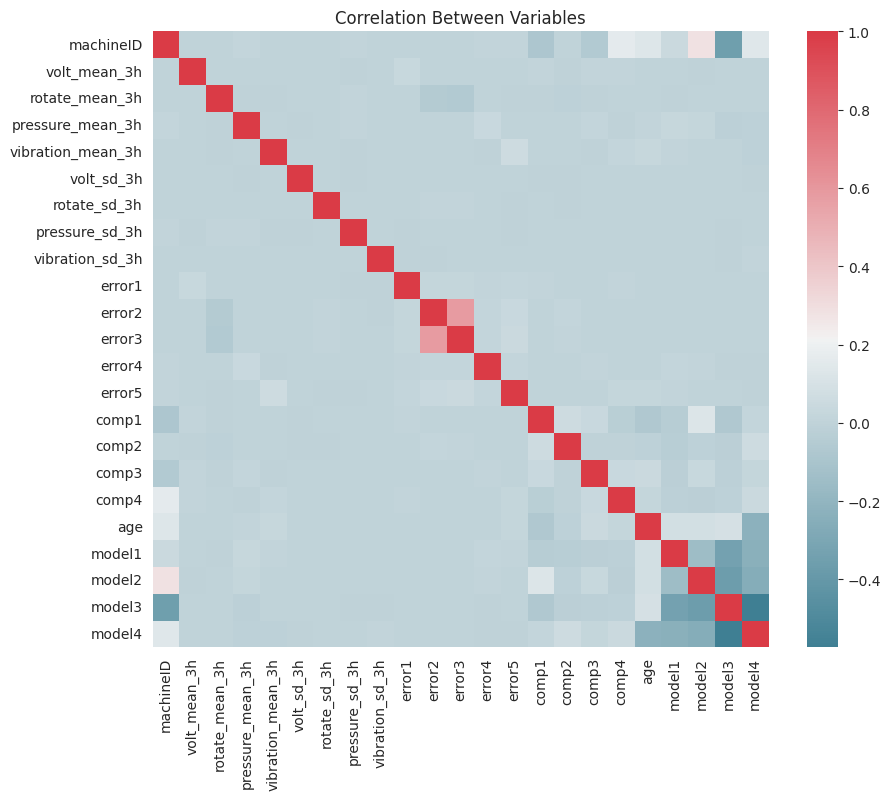

In [66]:
f, ax = plt.subplots(figsize=(10, 8))
corr = labeled_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title("Correlation Between Variables")
plt.show()

### 모델링

> Train / Test Split

In [67]:
threshold_dates = [
    pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")
]

In [68]:
test_results = []
models = []
total = len(threshold_dates)

last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [69]:
ntraining = labeled_features.loc[labeled_features["datetime"] < last_train_date]
ntesting = labeled_features.loc[labeled_features["datetime"] > first_test_date]
print(f"{ntraining.shape[0]} records for training")
print(f"{ntesting.shape[0]} records for testing")
print(f"{ntesting.shape[0] / ntraining.shape[0] * 100:0.1f}% of the data will be used for testing")

287537 records for training
95949 records for testing
33.4% of the data will be used for testing


> Target Feature Split

In [70]:
fails_train = ntraining[ntraining["failure"] != "none"].shape[0]
no_fails_train = ntraining[ntraining["failure"] == "none"].shape[0]
fails_test =ntesting[ntesting["failure"] != "none"].shape[0]
no_fails_test = ntesting[ntesting["failure"] == "none"].shape[0]

print(f"{fails_train / no_fails_train * 100:0.1f}% of the cases are training set failures")
print(f"{fails_test / no_fails_test * 100:0.1f}% of the cases are failures in the test set")

1.6% of the cases are training set failures
1.5% of the cases are failures in the test set


In [71]:
train_y = labeled_features.loc[labeled_features["datetime"] < last_train_date, "failure"].replace({'comp1':1, 'comp2':2, 'comp3':3, 'comp4':4, 'none':0})
train_X = labeled_features.loc[labeled_features["datetime"] < last_train_date].drop(["datetime", "machineID", "failure"], axis=1)
test_y = labeled_features.loc[labeled_features["datetime"] > first_test_date, "failure"].replace({'comp1':1, 'comp2':2, 'comp3':3, 'comp4':4, 'none':0})
test_X = labeled_features.loc[labeled_features["datetime"] > first_test_date].drop(["datetime", "machineID", "failure"], axis=1)

#### XGBoost Model

> Fitting

In [72]:
model = XGBClassifier(n_jobs=-1)
model.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)

> Prediction

In [73]:
test_result = pd.DataFrame(labeled_features.loc[labeled_features["datetime"] > first_test_date])
test_result["predicted_failure"] = model.predict(test_X)
test_results.append(test_result)

In [74]:
models.append(model)

#### Feature Importance

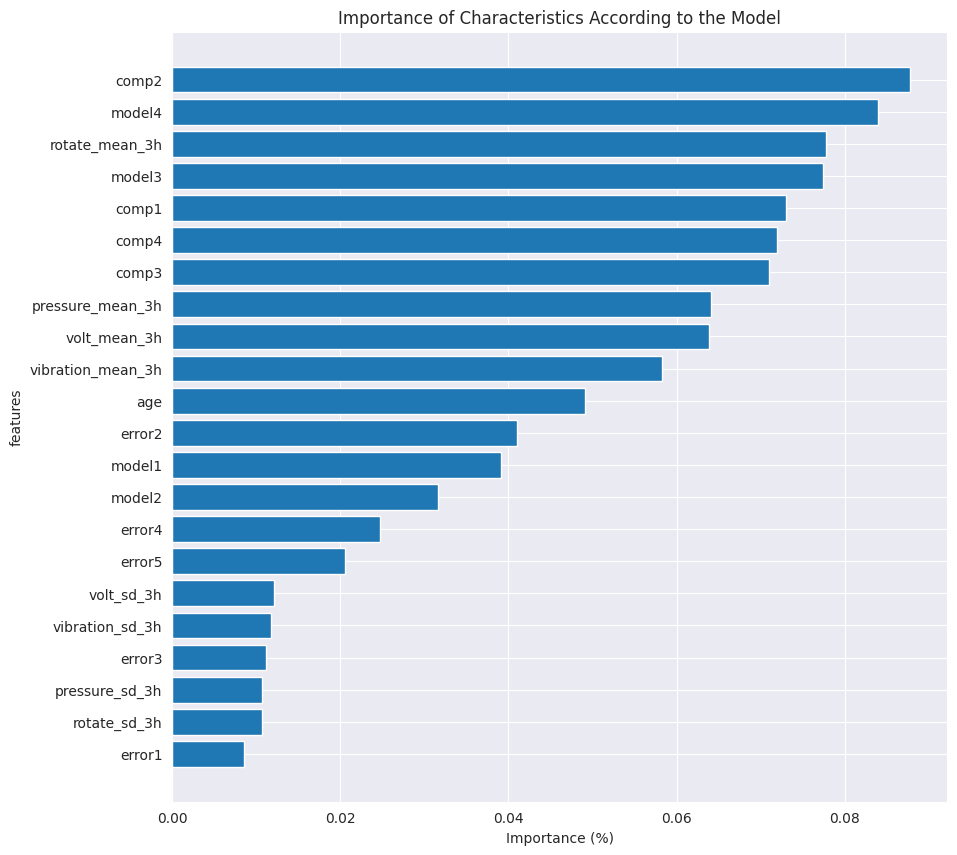

In [75]:
plt.figure(figsize=(10, 10))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=False, key=lambda x: x[1]))
plt.yticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.barh(range(len(importances)), importances)
plt.ylabel("features")
plt.xlabel("Importance (%)")
plt.title("Importance of Characteristics According to the Model")
plt.show()

#### 모델 평가 함수 생성

In [102]:
def evaluate(predicted, actual, labels):
  output_labels = []
  output = []

  # confusion matrix
  cm = confusion_matrix(actual, predicted, labels=labels)

  # precision, recall, and F1 score
  accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
  precision = precision_score(actual, predicted, average=None, labels=labels)
  recall = recall_score(actual, predicted, average=None, labels=labels)
  f1 = 2 * precision * recall / (precision + recall)
  output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
  output_labels.extend(["accuracy", "precision", "recall", "F1"])

  output_df = pd.DataFrame(output, columns=labels)
  output_df.index = output_labels

  return output_df

#### Confusion Matrix 평가

[[94148     0   160    34    81]
 [  162     0     6     1     2]
 [  251     0   314     4    10]
 [   23     0     0   195     1]
 [   33     0    17     1   235]]


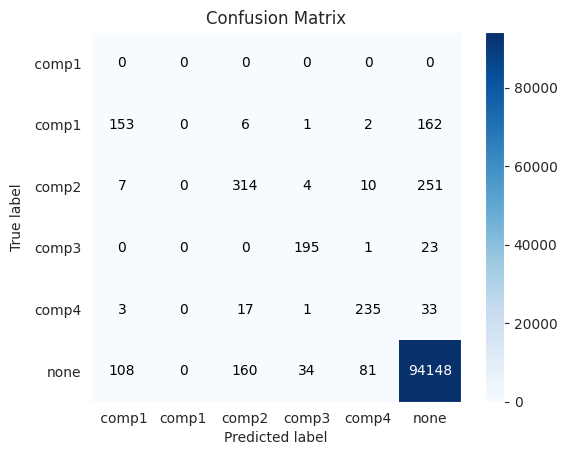

,none,comp1,comp2,comp3,comp4
accuracy,0.991785,0.991785,0.991785,0.991785,0.991785
precision,0.995043,0.000000,0.631791,0.829787,0.714286
recall,0.995948,0.000000,0.535836,0.890411,0.813149
F1,0.995496,NaN,0.579871,0.859031,0.760518


In [104]:
evaluation_results = []
test_result = test_results[0]
evaluation_result = evaluate(actual=test_result["failure"],
                             predicted=test_result["predicted_failure"].replace({1:' comp1', 2: 'comp2', 3: 'comp3', 4: 'comp4', 0: 'none'}),
                             labels=["none", "comp1", "comp2", "comp3", "comp4"])
skplt.metrics.plot_confusion_matrix(
    test_result["failure"],
    test_result["predicted_failure"].replace({1:' comp1', 2: 'comp2', 3: 'comp3', 4: 'comp4', 0: 'none'}),
    normalize=False,
    title="Confusion Matrix"
)
plt.show()

evaluation_results.append(evaluation_result)
evaluation_results[0]

#### Accuracy-Sensitivity 곡선

- 재현율: 실제 Positive인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요
- 정말도: 실제 Negative 데이터 예측을 Positive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 중요

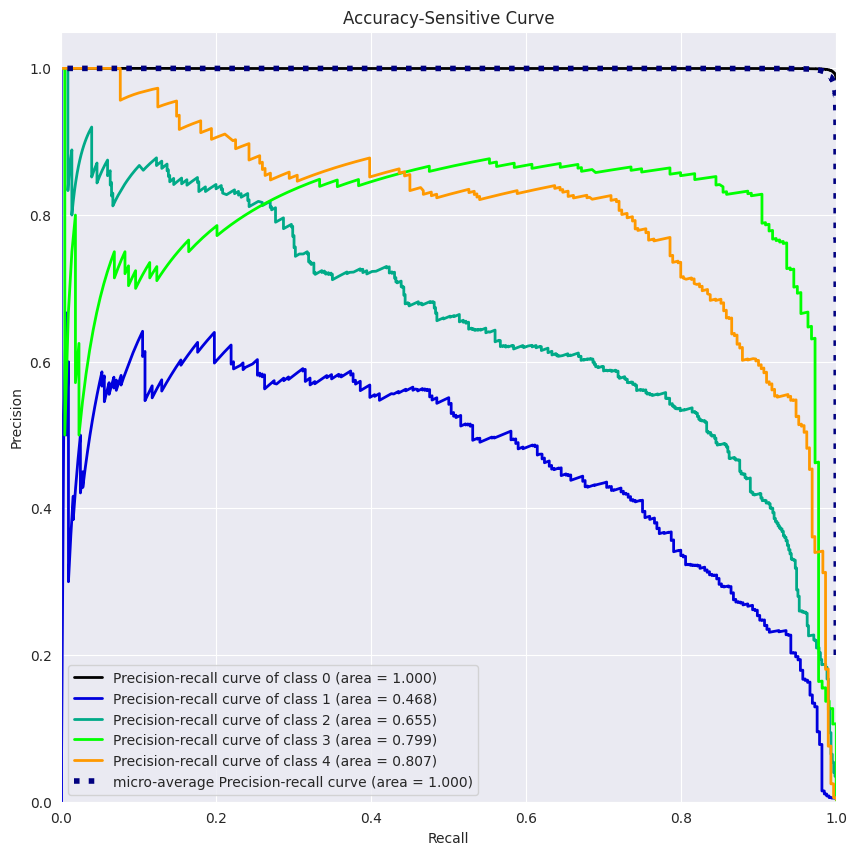

In [105]:
skplt.metrics.plot_precision_recall_curve(
    test_y,
    model.predict_proba(test_X),
    title="Accuracy-Sensitive Curve",
    figsize=(10, 10)
)
plt.show()

In [106]:
recall_df = pd.DataFrame([evaluation_results[0].loc["recall"].values],
                         columns=["none", "comp1", "com2", "comp3", "comp4"],
                         index=["Component Sensitivity"])
recall_df.T

,Component Sensitivity
none,0.995948
comp1,0.000000
com2,0.535836
comp3,0.890411
comp4,0.813149


> 예측 테스트

In [107]:
test_values = train_X.iloc[0].values
test_values

array([170.02899277, 449.53379775,  94.5921219 ,  40.89350186,
         6.7210322 ,  67.84959946,  18.93495636,   5.87496979,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  19.125     , 214.125     , 154.125     ,
       169.125     ,  18.        ,   0.        ,   0.        ,
         1.        ,   0.        ])

In [108]:
single_test = pd.DataFrame([test_values], columns=test_X.columns, index=[0])
single_test

,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_sd_3h,rotate_sd_3h,pressure_sd_3h,vibration_sd_3h,error1,error2,...,error5,comp1,comp2,comp3,comp4,age,model1,model2,model3,model4
0,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.87497,0.0,0.0,...,0.0,19.125,214.125,154.125,169.125,18.0,0.0,0.0,1.0,0.0


In [109]:
probas = model.predict_proba(single_test)
prediction = model.predict(single_test)
ordered_classes = np.unique(np.array(test_y))

In [113]:
results = pd.DataFrame(probas,
                       columns=ordered_classes,
                       index=[0])
print(f"Prediction: {prediction[0]}")
results.rename(columns={1:' comp1', 2: 'comp2', 3: 'comp3', 4: 'comp4', 0: 'none'})

Prediction: 0


,none,comp1,comp2,comp3,comp4
0,0.998725,0.001226,0.000041,0.000003,0.000006
